In [109]:
import importlib
import ase.io as aio

import os
import numpy as np
import qml
import ase
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/hitp/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/analysis/derivatives/')
from prepare_calculations import *
import explore_qml_data as eqd
import utils_qm as uqm
import glob
import cpmd_io

from matplotlib import pyplot as plt
import alchemical_derivatives as ad
import scipy.interpolate as si
importlib.reload(ad)

<module 'alchemical_derivatives' from '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/analysis/derivatives/alchemical_derivatives.py'>

In [122]:
import numpy as np
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# def pick_derivative(lam, ddlam, dE_dlam):
#     lam_val = ddlam[np.where(ddlam==lam)]
#     dE_val = dE_dlam[np.where(lam == ddlam)]
#     return(lam_val[0], dE_val[0])

def pick_derivative(lam_arr, dE_dlam_arr, lam):
    idx = find_nearest_idx(lam_arr, lam)
    return(lam_arr[idx], dE_dlam_arr[idx])

def pick_derivatives(lam_arr, dE_dlam_arr, lams):
    ddlam = []
    dE_dlam = []
    for l in lams:
        out = pick_derivative(lam_arr, dE_dlam_arr, l)
        ddlam.append(out[0])
        dE_dlam.append(out[1])
    return(ddlam, dE_dlam)

In [123]:
lambda_values, logfile_paths = ad.sort_lambda_logfiles('/data/sahre/projects/atomic-energies/derivatives/H2/small_dlambda/lam_*')
energy_contributions, e_el_cpmd, nuc_rep_cpmd = ad.get_energy_contributions(logfile_paths)
e_el_exact = e_el_cpmd[-2] - e_el_cpmd[0]

lambda_values_part, logfile_paths_part = ad.sort_lambda_logfiles('/data/sahre/projects/atomic-energies/derivatives/H2/partial_derivatives/H2_lam_*')
energy_contributions_part, e_el_cpmd_part, nuc_rep_cpmd_part = ad.get_energy_contributions(logfile_paths_part)

In [155]:
energy_contributions

{'TOTAL ENERGY =': array([-0.17800565, -0.17800565, -0.17813645, -0.17813652, -0.17902278,
        -0.17902309, -0.18161163, -0.1816124 , -0.18704929, -0.18705074,
        -0.19730251, -0.1973049 , -0.21197614, -0.21197964, -0.23256039,
        -0.23256515, -0.25973012, -0.25973625, -0.29400352, -0.29401112,
        -0.33579735, -0.33580647, -0.38524802, -0.38525868, -0.44240224,
        -0.44241443, -0.5070669 , -0.50708056, -0.57886568, -0.57888072,
        -0.65971003, -0.65972638, -0.7444845 , -0.74450204, -0.83496612,
        -0.83498476, -0.93075476, -0.93077443, -1.03150072, -1.03152134,
        -1.13689618, -1.1369177 ]),
 'KINETIC ENERGY =': array([0.00000000e+00, 0.00000000e+00, 8.77280000e-04, 8.77680000e-04,
        4.50096000e-03, 4.50208000e-03, 1.27234200e-02, 1.27256500e-02,
        2.73330200e-02, 2.73366600e-02, 4.93827100e-02, 4.93879000e-02,
        7.91363300e-02, 7.91430500e-02, 1.16446660e-01, 1.16454860e-01,
        1.61043360e-01, 1.61052990e-01, 2.12631170e-01

In [143]:
# e_el_cpmd = energy_contributions['TOTAL ENERGY =']
# e_el_exact = e_el_cpmd[-2] - e_el_cpmd[0]
# e_el_cpmd_part = energy_contributions_part['TOTAL ENERGY =']

e_el_cpmd = nuc_rep_cpmd
e_el_exact = nuc_rep_cpmd[-2] - nuc_rep_cpmd[0]
e_el_cpmd_part = nuc_rep_cpmd_part

In [149]:
nuc_rep_cpmd[-2]

0.27666219999999997

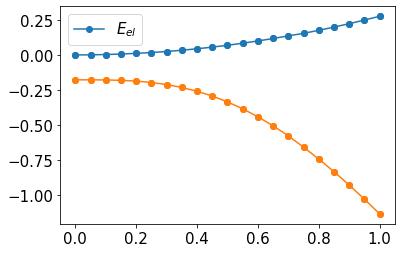

In [144]:
plt.plot(lambda_values, e_el_cpmd, '-o', label = r'$E_{el}$')

plt.plot(lambda_values, energy_contributions['TOTAL ENERGY ='], '-o')
plt.legend()

In [145]:
derivatives = {'lam':[], 'H':[]}

dE_dlam = []
ddlam = []
for i in range(0, len(lambda_values), 2):
    dE_dlam.append((e_el_cpmd[i+1]-e_el_cpmd[i])/(lambda_values[i+1]-lambda_values[i]))
    ddlam.append((lambda_values[i+1]+lambda_values[i])/2)
derivatives['lam'] = np.array(dE_dlam)
ddlam = np.array(ddlam)

for e_el_d, e_el in zip(e_el_cpmd_part, e_el_cpmd[::2]):
    derivatives['H'].append((e_el_d-e_el)/1e-5)
derivatives['H'] = np.array(derivatives['H'])

In [146]:
ngpts = [3,5,10,21]
errors = {'lam':[], 'H':[]}

for n in ngpts:
    lamvals = np.linspace(0, 1, n)
    int_x, int_y = pick_derivatives(ddlam, derivatives['lam'], lamvals)
    errors['lam'].append(np.trapz(int_y, int_x)-e_el_exact)
    
    int_x, int_y = pick_derivatives(ddlam, derivatives['H'], lamvals)
    errors['H'].append(2*np.trapz(int_y, int_x)-e_el_exact)

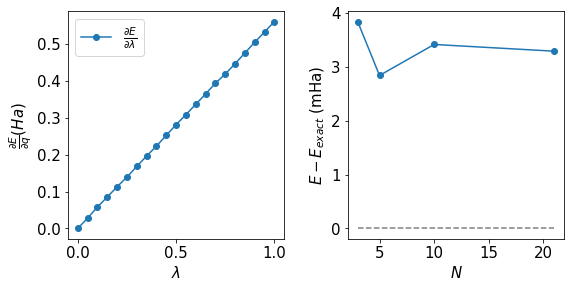

In [156]:
plt.rcParams['font.size'] = 15
fig, ax = plt.subplots(1,2)
fig.set_figwidth(8)
fig.tight_layout()

ax[0].plot(ddlam, derivatives['lam'], '-o', label = r'$\frac{\partial E}{\partial \lambda}$')
# ax[0].plot(ddlam, derivatives['H'], '-o', label = r'$\frac{\partial E}{\partial H}$' )
# ax[0].plot(ddlam, 2*derivatives['H'], '--')
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel(r'$\frac{\partial E}{\partial q} (Ha)$')

ax[1].plot(ngpts, 1000*np.array(errors['lam']), '-o')
# ax[1].plot(ngpts, 1000*np.array(errors['H']), '-o')
ax[1].plot(ngpts, len(ngpts)*[0], '--', color = 'tab:gray')
ax[1].set_xlabel(r'$N$')
ax[1].set_ylabel(r'$E-E_{exact}$ (mHa)')
ax[0].legend()

# plt.savefig('/home/sahre/projects/derivatives/figures/H2_e_nuc_convergence.png', bbox_inches = 'tight', dpi = 300)

In [150]:
ppoly = si.CubicSpline(ddlam, derivatives['lam'], axis=0, bc_type='not-a-knot', extrapolate=None)

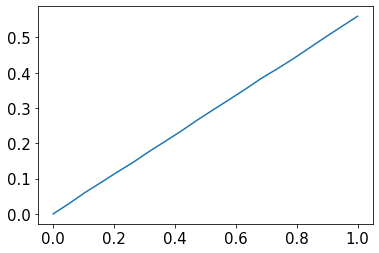

In [151]:
# plt.plot(ddlam, derivatives['lam'])
plt.plot(np.linspace(0,1,20), ppoly(np.linspace(0,1,20)))

In [154]:
ppoly.integrate(0,1)-nuc_rep_cpmd[-2]

0.0032673068886490686

In [141]:
errors

{'lam': [-0.035109469999933474,
  -0.006609470002194251,
  0.0012655299976428447,
  0.00274052999636476],
 'H': [-0.035109470004158316,
  -0.006609470006669338,
  0.0013905300002219345,
  0.0027905299980972575]}